In [1]:
from tensorflow.keras.metrics import Recall, Precision
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
import pandas as pd
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
import cv2
import keras
from keras import regularizers
from keras import optimizers
from keras import metrics
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import ELU, PReLU, LeakyReLU
from keras.utils.np_utils import to_categorical
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.applications import MobileNetV2, VGG16
from keras.models import load_model
from PIL import Image
import cv2
import PIL

In [2]:
# Configuración de parámetros
width = 224
height = 224
channel = 3
image_size = (width, height)

In [3]:
# Carga de imágenes
dirname = os.path.join(os.getcwd(), 'D:\Tesis\DATASET\Training')
imgpath = dirname + os.sep
images = []
directories = []
dircount = []
prevRoot = ''
cant = 0

print("leyendo imagenes de", imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant += 1
            filepath = os.path.join(root, filename)
            image = cv2.imread(filepath)
            image = cv2.resize(image, image_size)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print(b, end="\r")
            if prevRoot != root:
                print(root, cant)
                prevRoot = root
                directories.append(root)
                dircount.append(cant)
                cant = 0
dircount.append(cant)

dircount = dircount[1:]
dircount[0] = dircount[0] + 1
print('Directorios leidos:', len(directories))
print("Imagenes en cada directorio", dircount)
print('Suma Total de imagenes en subdirs:', sum(dircount))

leyendo imagenes de D:\Tesis\DATASET\Training\
D:\Tesis\DATASET\Training\Glioma 1
D:\Tesis\DATASET\Training\Meningioma 904
D:\Tesis\DATASET\Training\Pituitaria 904
Directorios leidos: 3
Imagenes en cada directorio [905, 904, 887]
Suma Total de imagenes en subdirs: 2696


In [4]:
# Etiquetado de las imágenes
labels = []
indice = 0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice += 1
print("Cantidad etiquetas creadas:", len(labels))

tumores = []
indice = 0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice, name[len(name)-1])
    tumores.append(name[len(name)-1])
    indice += 1

y = np.array(labels)
X = np.array(images, dtype='float32')


Cantidad etiquetas creadas: 2696
0 Glioma
1 Meningioma
2 Pituitaria


In [5]:
# División en entrenamiento, validación y prueba
X, y = shuffle(X, y)
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.3)

print('Forma de los datos de entrenamiento:', train_X.shape, train_Y.shape)
print('Forma de los datos de prueba:', test_X.shape, test_Y.shape)

Forma de los datos de entrenamiento: (1887, 224, 224, 3) (1887,)
Forma de los datos de prueba: (809, 224, 224, 3) (809,)


In [6]:
# Normalización de los datos y one-hot encoding
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

In [7]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
datagen.fit(train_X)

In [8]:
# Creación del modelo
modelo_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(width, height, channel))
x = modelo_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.5)(x)
predicciones = Dense(len(tumores), activation='softmax')(x)
modelo = Model(inputs=modelo_base.input, outputs=predicciones)


In [10]:
modelo.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
historia = modelo.fit(datagen.flow(train_X, train_Y_one_hot, batch_size=40), epochs=30, validation_data=(test_X, test_Y_one_hot))


Epoch 1/30
48/48 [==============================] - 251s 5s/step - loss: 0.6821 - accuracy: 0.7244 - val_loss: 2.6920 - val_accuracy: 0.4363
Epoch 2/30
48/48 [==============================] - 235s 5s/step - loss: 0.4416 - accuracy: 0.8341 - val_loss: 1.9269 - val_accuracy: 0.5661
Epoch 3/30
48/48 [==============================] - 234s 5s/step - loss: 0.3606 - accuracy: 0.8622 - val_loss: 1.6283 - val_accuracy: 0.5859
Epoch 4/30
48/48 [==============================] - 233s 5s/step - loss: 0.3044 - accuracy: 0.8882 - val_loss: 1.6347 - val_accuracy: 0.5587
Epoch 5/30
48/48 [==============================] - 232s 5s/step - loss: 0.2773 - accuracy: 0.8983 - val_loss: 1.3369 - val_accuracy: 0.6032
Epoch 6/30
48/48 [==============================] - 231s 5s/step - loss: 0.2632 - accuracy: 0.8998 - val_loss: 1.1540 - val_accuracy: 0.6354
Epoch 7/30
48/48 [==============================] - 233s 5s/step - loss: 0.2167 - accuracy: 0.9131 - val_loss: 1.2437 - val_accuracy: 0.5859
Epoch 8/30
48

In [11]:
# Evaluación del modelo
puntuacion = modelo.evaluate(test_X, test_Y_one_hot)
print('Pérdida en la prueba:', puntuacion[0])
print('Precisión en la prueba:', puntuacion[1])

26/26 [==============================] - 17s 659ms/step - loss: 0.2584 - accuracy: 0.9048
Pérdida en la prueba: 0.25843408703804016
Precisión en la prueba: 0.9048207402229309


26/26 [==============================] - 18s 656ms/step


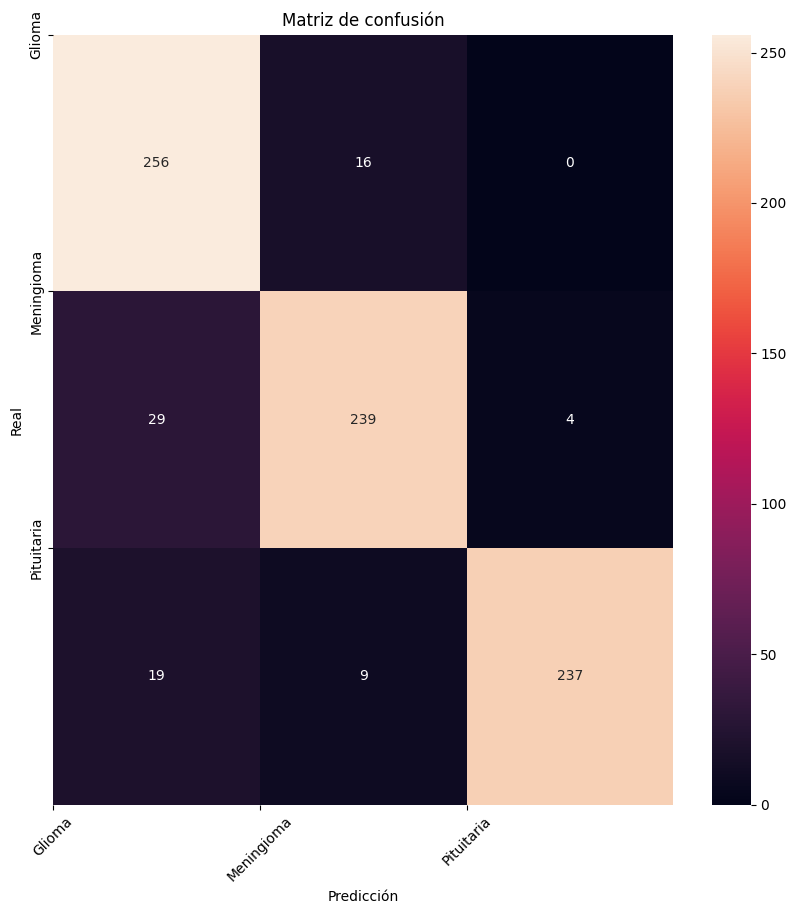

In [12]:
# Matriz de confusión
Y_pred = modelo.predict(test_X)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_Y, y_pred)

# Plot matriz de confusión
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(np.arange(len(tumores)), tumores, rotation=45)
plt.yticks(np.arange(len(tumores)), tumores)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

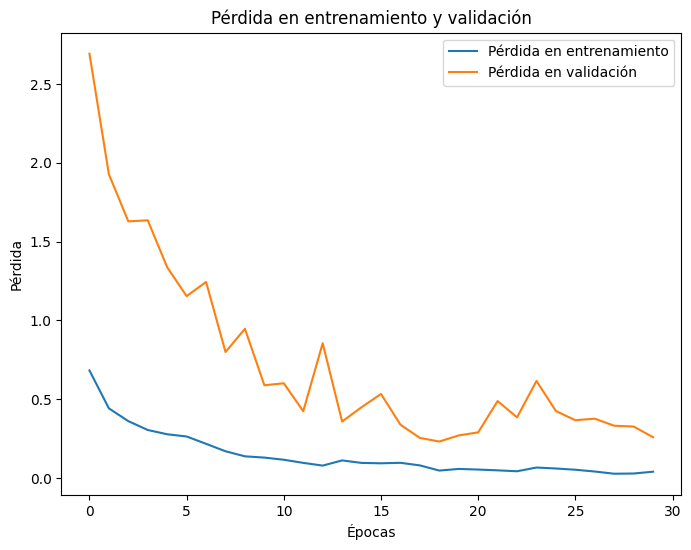

In [13]:
# Gráfico de pérdida
plt.figure(figsize=(8, 6))
plt.plot(historia.history['loss'], label='Pérdida en entrenamiento')
plt.plot(historia.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida en entrenamiento y validación')
plt.legend()
plt.show()

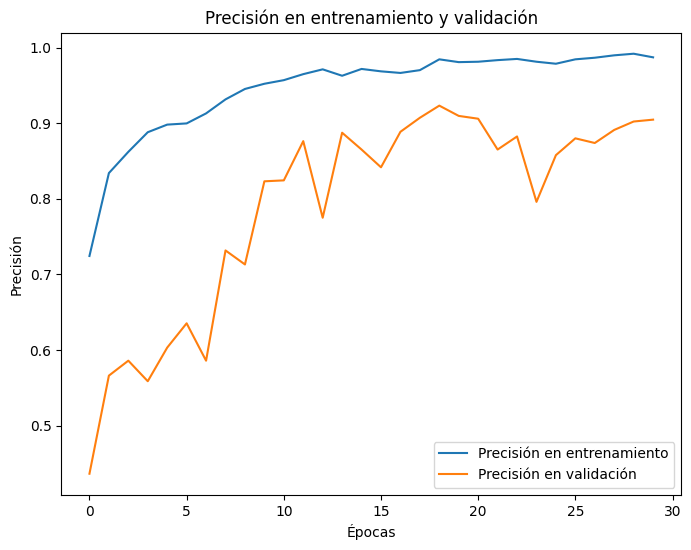

In [14]:
# Gráfico de precisión
plt.figure(figsize=(8, 6))
plt.plot(historia.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(historia.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión en entrenamiento y validación')
plt.legend()
plt.show()

In [15]:
# Guardar el modelo
modelo.save('tipo_3.h5')

In [16]:
from sklearn.metrics import accuracy_score

# Obtener las etiquetas reales
y_true = np.argmax(test_Y_one_hot, axis=1)

# Obtener las etiquetas predichas
y_pred = np.argmax(Y_pred, axis=1)

# Calcular el porcentaje de validez
accuracy = accuracy_score(y_true, y_pred)

# Imprimir el porcentaje de validez
print("Porcentaje de validez del algoritmo de IA: {:.2%}".format(accuracy))

Porcentaje de validez del algoritmo de IA: 90.48%
